# **Identifying fraduluent transactions** - using XGBoost + scale_pos_weight

## **Introduction**

The current project aims to create a model to identify *fraduluent* transactions from the *non-fraduluent* transactions. This problem is a classic example of **classification with a highly imbalanced dataset**. The goal is not just to predict, but to create a model that is both effective and practical for business implementation.

### **About the Dataset**

The details of the features in the dataset are:
Details of columns are:
1. **step:** denotes a portion of time period
2. **type:** Type of transaction (PAYMENT/CASH_OUT/DEBIT/TRANSFER etc.)
3. **amount:** Amount of transaction
4. **nameOrig:** Name of source account
5. **oldbalanceOrg:** Old balance of source account
6. **newbalanceOrig:** New Balance of source account
7. **nameDest:** Name of target Account
8. **oldbalanceDest:** Old balance of target account
9. **newbalanceDest:** New balacne of target account
10. **isFraud:** 1 for Fraud, 0 for not
11. **isFlaggedFraud:** 0/1 based on the existing mechanism.

### **Plan of Action**
1. **Data Cleaning and Preprocessing**: Dealing with Missing Values and Outliars if required.
2. **Identifying trends** in various features
3. **Multi-collinearity**: Identify predictor variables which are highly dependendent on each other. If required drop those features, since they are redundant to the final predictors. Their existance may only marginally improve the model, and computational cost may be high
4. **Model selection** based on the values and nature of outliars, multi-linearity and sampling methods, best model for this problem will be chosen
5. **Feature Engineering**: If required new features will be added.
6. **Feature Importance**: Initially, all engineered and relevant original features will be included. After training the initial XGBoost model, we can use its built-in feature importance plot to select the most predictive variables.
7. **Model performance**: Check performance of the model using **Confusion Matrix, Recall (Sensitivity), Precision, Area Under Precision Recall Curve (AUC-PR)**. A model with a high AUC-PR can achieve high recall while maintaining good precision. This is the most effective metrics to evaluate a model for imbalenced dataset.
8. **Threshold Evaluation**: Using the The PR curve best threshold will be chosen. For example, a bank might choose a lower threshold to increase Recall (catch more fraud), even if it means slightly lower Precision (more false alarms for the investigation team to handle).
9. **Recommendations and Prevention Measures**: Based on the model and results, final conclusion and strategies will be identified

### Exploratory Data Analysis

In [1]:
# Import necessary libraries for EDA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style
plt.style.use('seaborn-v0_8-whitegrid')


In [2]:
# Load Dataset
df = pd.read_csv('/content/Fraud.csv')

In [ ]:
# Displaying the dataset
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [3]:
# Info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [4]:
# Checking total number of fraud transactions
df.isFraud.value_counts()

,count
isFraud,
0,6354407
1,8213


In [5]:
# Percentage of total Frauds
round((df['isFraud'].value_counts()[1]/df.shape[0]) *100,2)

np.float64(0.13)

Only 0.13% of total dataset *isFraud*. The dataset is **highly imbalanced**. Need to be very careful during outliar detection and training the model.

<Axes: xlabel='type', ylabel='amount'>

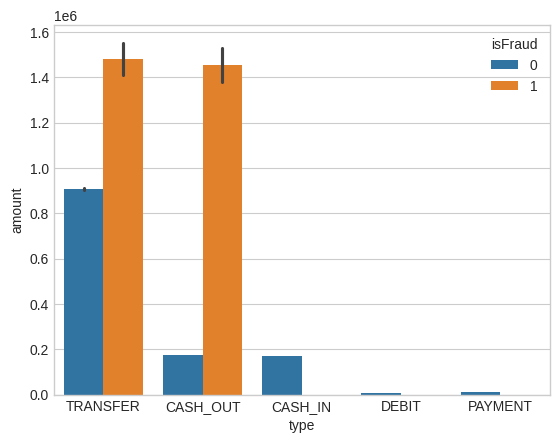

In [6]:
# Creating a barplot to check the average transaction amount per transaction type
# in both fraudulent and non-fradulent categories
sorted_categories = df.sort_values(by='amount', ascending=False)['type'].tolist()
sns.barplot(data = df, order = sorted_categories, x = 'type', y = 'amount', hue = 'isFraud')

On an average, the fraudulent transaction amount is higher. The only transaction types affected by frauds are **TRANSFER** and **CASH_OUT**

In [7]:
# Checking total number of Flagged Fraud transactions
df.isFlaggedFraud.value_counts()

,count
isFlaggedFraud,
0,6362604
1,16


*High inaccuracy in the current method* of evaluating Fraud Transactions. **Only 16 (0.19%) of the total fraudlent transactions have been flagged correctly**

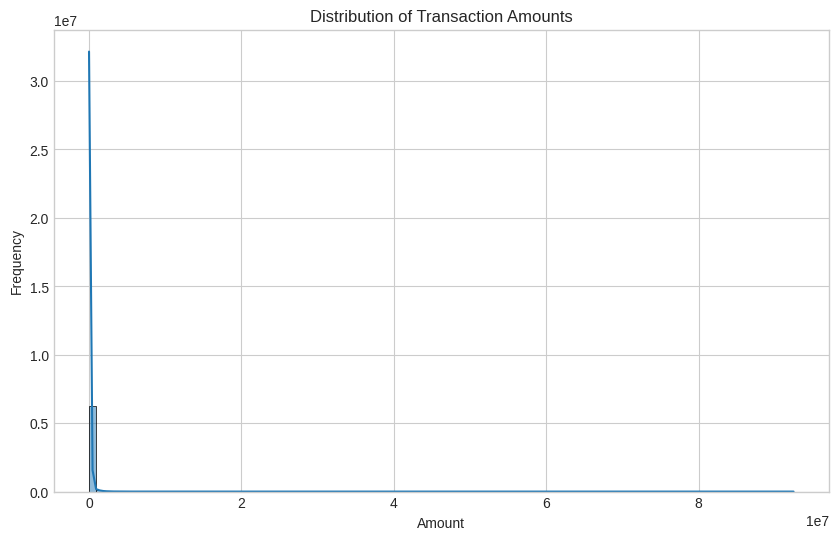

In [8]:
# Distribution of transaction amounts
plt.figure(figsize=(10, 6))
sns.histplot(df['amount'], bins=100, kde=True)
plt.title('Distribution of Transaction Amounts')
plt.xlabel('Amount')
plt.ylabel('Frequency')
plt.show()

Data is skewed due to presence of outliars (as expected from an imbalanced dataset). **Log Transfromation** should give a *smoother distribution*.

Text(0, 0.5, 'Frequency')

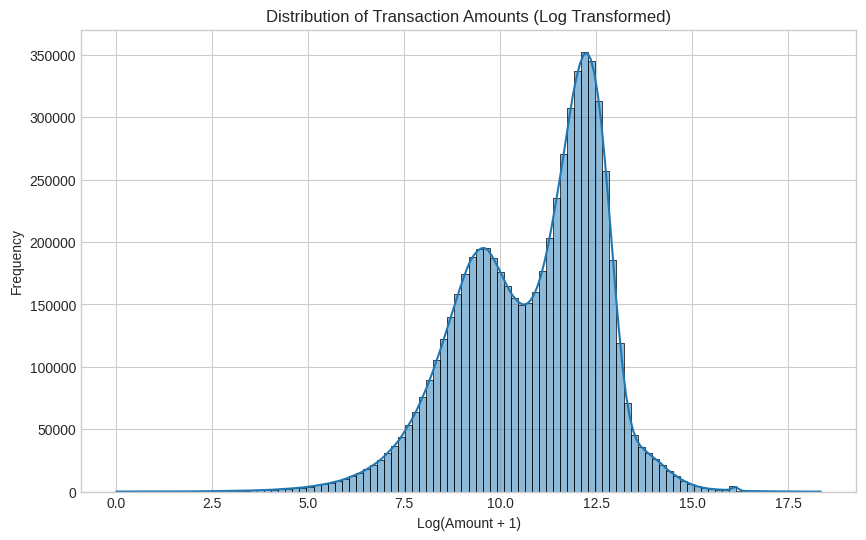

In [9]:
# Distribution of transaction amounts using log transformation for smoother distribution
plt.figure(figsize=(10, 6))
sns.histplot(np.log1p(df['amount']), bins=100, kde=True)
plt.title('Distribution of Transaction Amounts (Log Transformed)')
plt.xlabel('Log(Amount + 1)')
plt.ylabel('Frequency')

## Missing values and Outliar detection

In [10]:
# Check for missing values
print("Missing values per column:")
print(df.isnull().sum())

Missing values per column:
step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64


*No Missing Values Found!*

### **Amount** Statistics

In [11]:
# Statistical Description for 'amount'
df['amount'].describe().astype(int)

,amount
count,6362620
mean,179861
std,603858
min,0
25%,13389
50%,74871
75%,208721
max,92445516


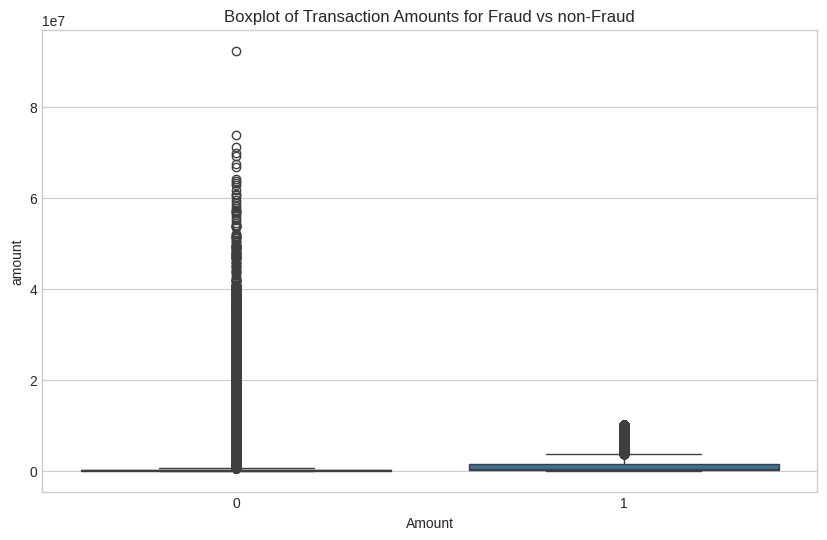

In [12]:
# Checking boxplot distribution
plt.figure(figsize=(10, 6))
sns.boxplot(data = df, x = 'isFraud', y = 'amount')
plt.title('Boxplot of Transaction Amounts for Fraud vs non-Fraud')
plt.xlabel('Amount')
plt.show()

Highly skewed data, **does not make sence to remove outliars**, since removal of outliars may mean we get rid of most important data points for this model. Just for assessment and clear analysis, we will try to remove outliars using IQR and check the distribution

#### Outliar removal using IQR to check if it could be used

In [13]:
# Removing outliars using IQR

# Calculating Q1 and Q3
Q1 = df.amount.quantile(0.25)
Q3 = df.amount.quantile(0.75)

# Defining IQR
IQR = Q3-Q1

# Defining lower and upper bounds for the dataframe
lower_bound = Q1 - (1.5 * IQR)
upper_bound = Q3 + (1.5 * IQR)

# Filtering the dataframe to remove outliars
df_cleaned = df[(df['amount'] >= lower_bound) & (df['amount'] <= upper_bound)]

<Axes: xlabel='amount', ylabel='Count'>

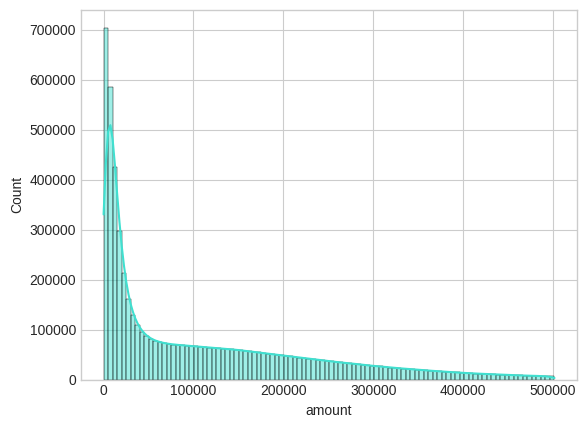

In [14]:
# Distribution of the cleaned dataset
sns.histplot(df_cleaned.amount,bins = 100, kde = True, color = 'turquoise')

In [15]:
# Count of new cleaned dataset
df_cleaned.isFraud.value_counts()

,count
isFraud,
0,6020183
1,4359


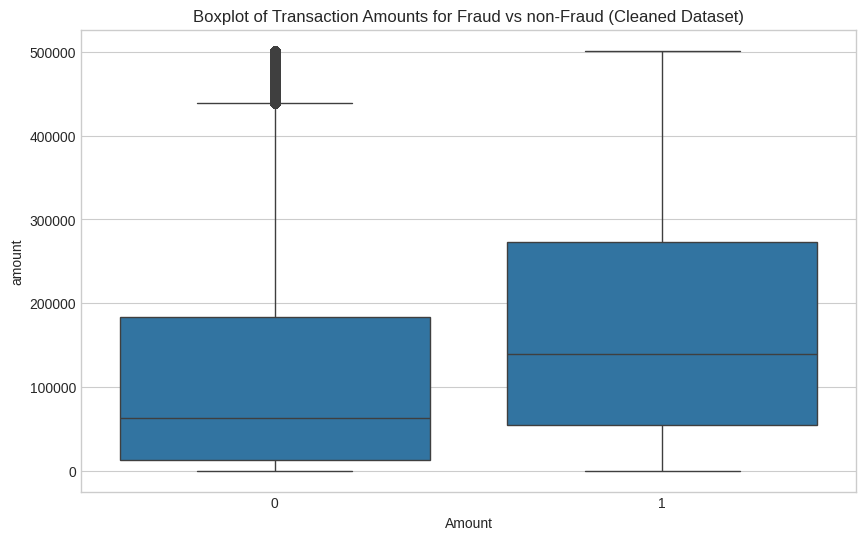

In [16]:
# Checking boxplot distribution
plt.figure(figsize=(10, 6))
sns.boxplot(data = df_cleaned, x = 'isFraud', y = 'amount')
plt.title('Boxplot of Transaction Amounts for Fraud vs non-Fraud (Cleaned Dataset)')
plt.xlabel('Amount')
plt.show()

As expected, doing this IQR outliar removal **got rid of almost 50% of the minority data points**, which means, this method is **not optimal** for outliar treatment in this case.

**Continuing without dropping any outliars** to preserve the marginal datapoints as they are helpful in Fraud detection.. In fraud detection, outliers are often the fraudulent transactions themselves. Removing them is **counterproductive**, as we would be removing the very data we want the model to learn. **Tree-based models like XGBoost are also naturally robust to the magnitude of outliers**

### Relevance of Step Feature

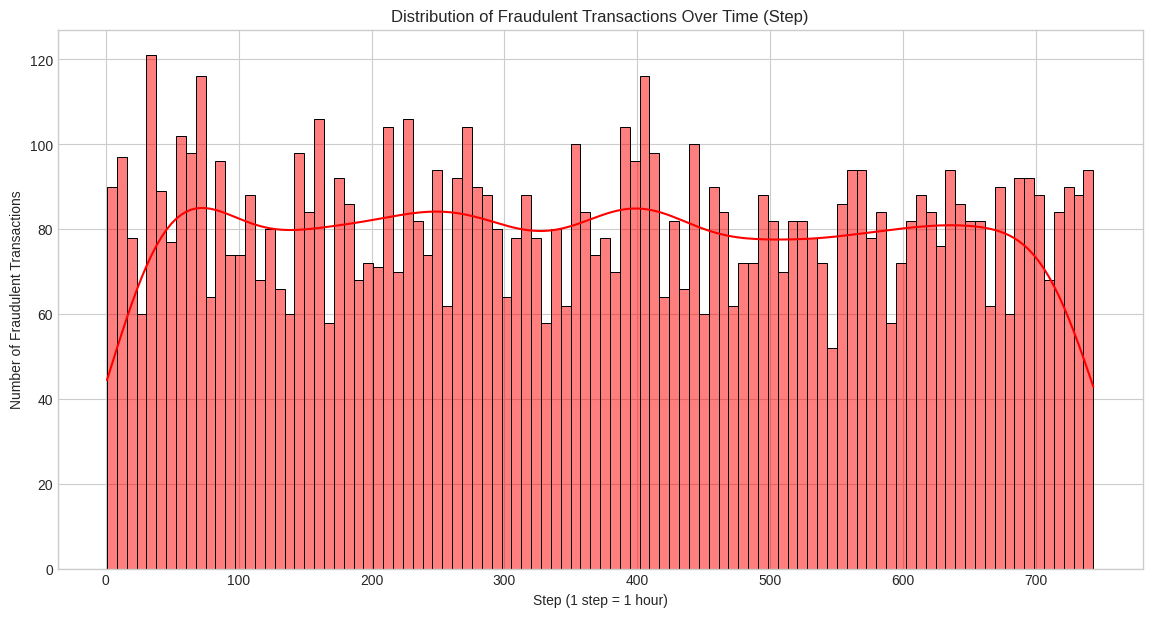

In [17]:
# Filter the original dataframe to include only fraudulent transactions
fraudulent_df = df[df['isFraud'] == 1]

# Plot the distribution of frauds over time (step)
plt.figure(figsize=(14, 7))
sns.histplot(data=fraudulent_df, x='step', bins=100, kde=True, color='red')
plt.title('Distribution of Fraudulent Transactions Over Time (Step)')
plt.xlabel('Step (1 step = 1 hour)')
plt.ylabel('Number of Fraudulent Transactions')
plt.grid(True)
plt.show()

A histogram of the **step** (assuming step size to be an hour) for fraudulent transactions will show us if fraud occurs more frequently at specific times during the simulation.

**Analysis of the Plot:**

* The resulting histogram shows the frequency of fraudulent transactions at each hour (step) simulation. By looking at the plot, we may identify:

    * **Peaks and Troughs**: Are there specific times of the day or specific days where fraud is more common? You might observe a regular, cyclical pattern.

    * **Irregular Spikes**: Sudden, sharp spikes could indicate coordinated fraud attacks.


This temporal information can be highly valuable. For instance, if fraud peaks during specific hours, the security team could increase monitoring intensity during that window. It also provides another layer of features for more advanced models (e.g., creating a "high-risk hour" feature). Thus, **keeping this feature** for our prediction model

### Account wise analysis

In [18]:
# Frequency of Top Senders
df.nameOrig.value_counts().head(10)

,count
nameOrig,
C1530544995,3
C545315117,3
C724452879,3
C1784010646,3
C1677795071,3
C1462946854,3
C1065307291,3
C1999539787,3
C2098525306,3


In [19]:
# frequency of top fraudulent senders
df[df.isFraud == 1]["nameOrig"].value_counts().head(10)

,count
nameOrig,
C1280323807,1
C1305486145,1
C840083671,1
C1420196421,1
C2101527076,1
C1039979813,1
C2089752665,1
C1614818636,1
C40604503,1


In [20]:
# Frequency of Top Receivers
df.nameDest.value_counts().head(10)

,count
nameDest,
C1286084959,113
C985934102,109
C665576141,105
C2083562754,102
C248609774,101
C1590550415,101
C1789550256,99
C451111351,99
C1360767589,98


In [21]:
# Frequency of top fraudulent receivers
df[df.isFraud == 1]["nameDest"].value_counts().head(10)

,count
nameDest,
C1981613973,2
C410033330,2
C1366192319,2
C1655359478,2
C803116137,2
C52390890,2
C1325541393,2
C904300960,2
C2020337583,2


These features do not show any pattens, so the **account names could be dropped** from out final model

## Feature Engineering

In [22]:
# Create features to capture balance discrepancies, which can be a strong signal for fraud.
df['errorBalanceOrig'] = df['newbalanceOrig'] + df['amount'] - df['oldbalanceOrg']
df['errorBalanceDest'] = df['oldbalanceDest'] + df['amount'] - df['newbalanceDest']

In [23]:
# One-hot encode the 'type' column to convert it to a numerical format.
df = pd.get_dummies(df, columns=['type'], prefix='type', drop_first=True)

In [24]:
df.head()

,step,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,errorBalanceOrig,errorBalanceDest,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,1,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0,0.0,9839.64,False,False,True,False
1,1,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0,0.0,1864.28,False,False,True,False
2,1,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0,0.0,181.00,False,False,False,True
3,1,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0,0.0,21363.00,True,False,False,False
4,1,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0,0.0,11668.14,False,False,True,False


In [35]:
df.head()

,step,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,errorBalanceOrig,errorBalanceDest,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,1,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0,0.0,9839.64,False,False,True,False
1,1,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0,0.0,1864.28,False,False,True,False
2,1,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0,0.0,181.00,False,False,False,True
3,1,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0,0.0,21363.00,True,False,False,False
4,1,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0,0.0,11668.14,False,False,True,False


In [25]:

# Drop columns that are identifiers or redundant. 'isFlaggedFraud' is a simple rule
# that our more complex model will learn implicitly and improve upon.
df_processed = df.drop(['nameOrig', 'nameDest', 'isFlaggedFraud'], axis=1)

print("\nNew features created and irrelevant columns dropped.")
print("Processed data sample:")
display(df_processed.head())


New features created and irrelevant columns dropped.
Processed data sample:


,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,errorBalanceOrig,errorBalanceDest,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,1,9839.64,170136.0,160296.36,0.0,0.0,0,0.0,9839.64,False,False,True,False
1,1,1864.28,21249.0,19384.72,0.0,0.0,0,0.0,1864.28,False,False,True,False
2,1,181.00,181.0,0.00,0.0,0.0,1,0.0,181.00,False,False,False,True
3,1,181.00,181.0,0.00,21182.0,0.0,1,0.0,21363.00,True,False,False,False
4,1,11668.14,41554.0,29885.86,0.0,0.0,0,0.0,11668.14,False,False,True,False


In [ ]:
# also dropping type_DEBIT and type_PAYMENT, since no fradu

#### Correlation to find multicollinearity

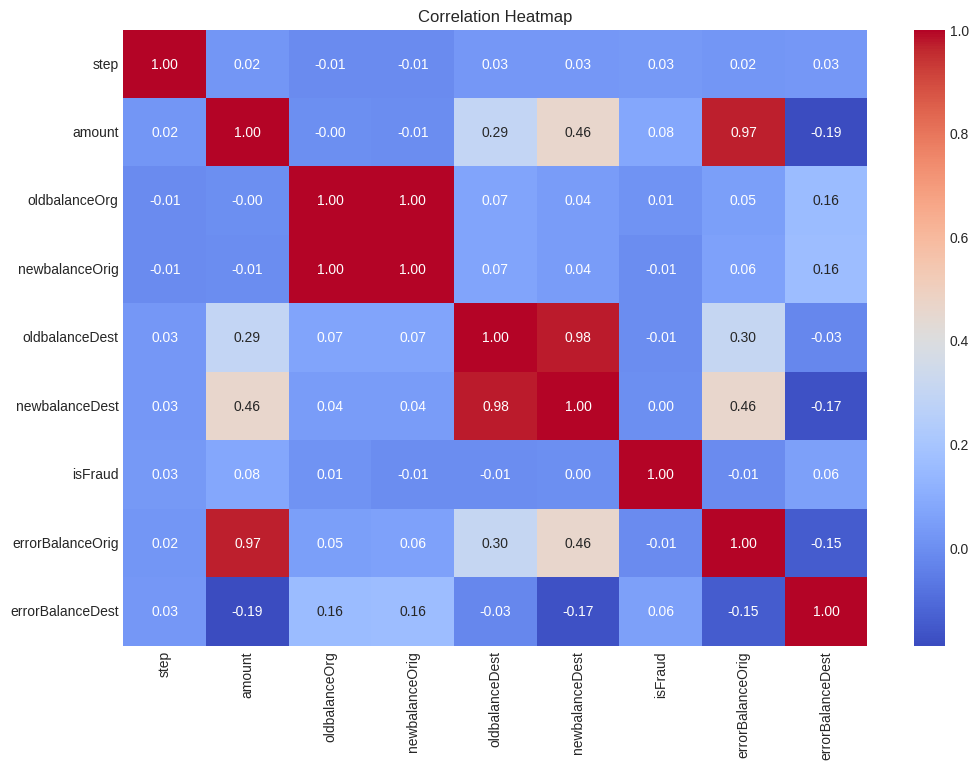

In [26]:
# We will drop non-numeric columns for the correlation matrix
numeric_df = df_processed.select_dtypes(include=np.number)

plt.figure(figsize=(12, 8))
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

If any features have high correlation with other features, they are likely to be dependent on each other, could lead to redundancy.

1. oldbalanceDest and newbalanceDest
2. oldbalanceOrg and newbalanceOrig

Since this is *not a major issue for XGBoost*, we are keeping these features.

### **Identified model for training: XGBoost with Cost Sensitive Learning**

Our dataset is highly imbalanced (isFraud = 1 is only 0.13% of the data). A standard model would achieve high accuracy by simply predicting "not fraud" every time. We need a model that can handle this imbalance.

* **XGBoost (eXtreme Gradient Boosting)** is an excellent choice because:

   1. **High Performance:** It is known for its predictive power on tabular data.

   2. **Handles Imbalance:** It includes a parameter ***scale_pos_weight*** that acts as a cost-sensitive learning mechanism. We set this to the ratio of negative to positive samples, forcing the model to pay significantly more attention to the minority (fraud) class during training. This sometimes performs *even better* than techniques such as **SMOTE**.
   
   3. **Insensitive to Outliars**: Tree-based models like XGBoost are also naturally robust to the magnitude of outliers. XGBoost is able to handle outliers well and still produce accurate predictions. This is due to the fact that XGBoost is a gradient boosting algorithm, which means it can adapt its learning rate depending on the amount of noise in the data.
   
   4. **Multi-collinearity** is not a major issue for XGBoost, since it automatically selects the best decision tree based. It builds an ensemble of decision trees. Each individual tree makes splits based on features that provide the most information gain at each node. If two features are highly correlated, the tree can choose either one to make a split, and the other correlated feature will still be available for subsequent splits if it offers additional information. The algorithm does not rely on independent feature contributions in the same way linear models do to estimate coefficients.
   
   5. **Scaling not needed in case of XGBoost:** We are going forward with train_test_split and cross validation.

   6. We will use all the engineered and relevant original features for the initial model. XGBoost has a built-in mechanism to assess feature importance, which we will use after training to understand which variables are the most predictive. This helps validate our feature choices and can be used to build simpler, more efficient models if needed.


### **Machine Learning**

In [27]:
# Import Modules for ML
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, average_precision_score, precision_recall_curve
from sklearn.model_selection import StratifiedKFold, cross_val_score

In [28]:
# Define features (X) and target (y)
X = df_processed.drop(columns='isFraud', axis=1)
y = df_processed['isFraud']

# Splitting test and training datasets
# This ensures the test set simulates unseen data.
# Split the data, ensuring the proportion of fraud cases is the same in both sets (stratify)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Data split into training and testing sets.")
print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)


Data split into training and testing sets.
Training set shape: (5090096, 12)
Testing set shape: (1272524, 12)


In [29]:

# Calculate scale_pos_weight
scale_pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]
print(f"Calculated Scale Pos Weight: {scale_pos_weight:.2f}\n")

# Initialize the XGBoost model with scale_pos_weight
model = XGBClassifier(
    objective='binary:logistic',
    scale_pos_weight=scale_pos_weight,
    use_label_encoder=False,
    eval_metric='aucpr',  # Area Under Precision-Recall Curve, not using log-loss since it may favour the majority class
    random_state=42,
)

# Cross-validation (Stratified) using average_precision (PR-AUC)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
print('Performing 5-fold cross-validation (average precision / PR-AUC)...')
cv_scores = cross_val_score(model, X_train, y_train, scoring='average_precision', cv=cv, n_jobs=-1)
print(f'PR-AUC scores per fold: {cv_scores}')
print(f'Mean PR-AUC: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}')

Calculated Scale Pos Weight: 773.75

Performing 5-fold cross-validation (average precision / PR-AUC)...
PR-AUC scores per fold: [0.99288053 0.98979324 0.99038151 0.99361068 0.99044753]
Mean PR-AUC: 0.9914 ± 0.0015


In [30]:

print("Training XGBoost model...")
model.fit(X_train, y_train)
print("Model training complete.")


Training XGBoost model...


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [13:01:02] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Model training complete.


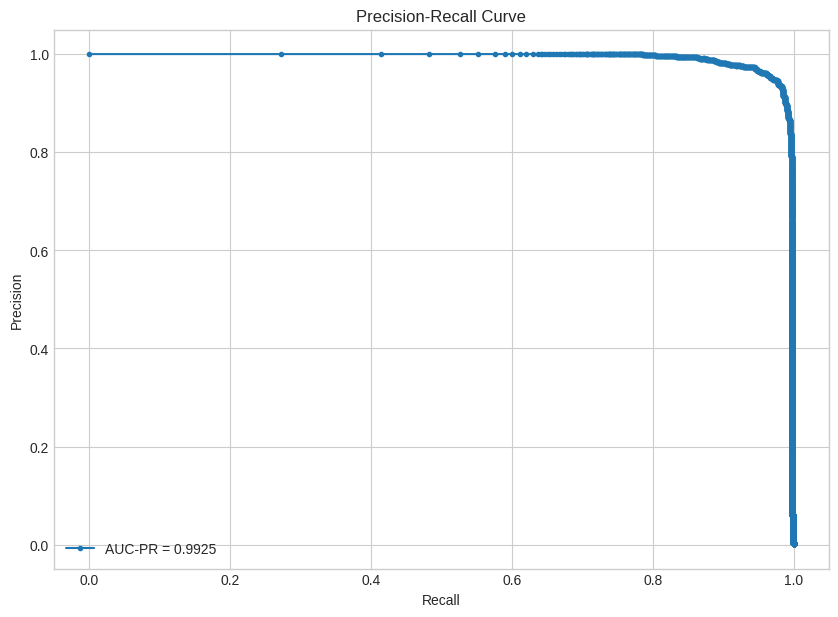

In [31]:

# Make predictions on the test set
y_pred_proba = model.predict_proba(X_test)[:, 1] # Get fraud probabilities

# Plot the Precision-Recall curve to visualize the trade-off
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)

plt.figure(figsize=(10, 7))
plt.plot(recall, precision, marker='.', label=f'AUC-PR = {average_precision_score(y_test, y_pred_proba):.4f}')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()


In [32]:
# Find the optimal threshold that maximizes the F1-score

# Calculate F1 score for each threshold (add epsilon to avoid division by zero)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-9)

# Find the threshold that corresponds to the highest F1 score
best_threshold_index = np.argmax(f1_scores)
best_threshold = thresholds[best_threshold_index]

print(f"Best Threshold for maximizing F1-Score: {best_threshold:.4f}")
print(f"Maximum F1-Score achieved: {f1_scores[best_threshold_index]:.4f}")

Best Threshold for maximizing F1-Score: 0.9870
Maximum F1-Score achieved: 0.9614



--- Final Classification Report (at Optimal Threshold) ---
              precision    recall  f1-score   support

   Not Fraud       1.00      1.00      1.00   1270881
       Fraud       0.95      0.98      0.96      1643

    accuracy                           1.00   1272524
   macro avg       0.97      0.99      0.98   1272524
weighted avg       1.00      1.00      1.00   1272524



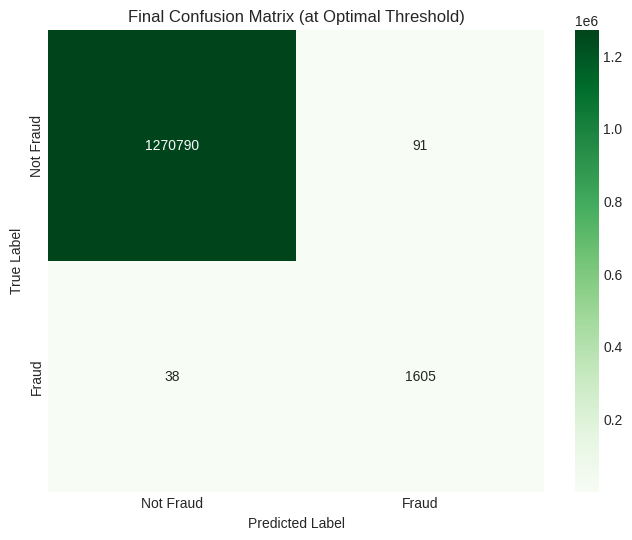

In [33]:
# Apply the optimal threshold to get the final predictions
y_pred_final = (y_pred_proba >= best_threshold).astype(int)

# --- Final Model Performance Report ---
print("\n--- Final Classification Report (at Optimal Threshold) ---")
print(classification_report(y_test, y_pred_final, target_names=['Not Fraud', 'Fraud']))

# Display the final Confusion Matrix
cm_final = confusion_matrix(y_test, y_pred_final)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_final, annot=True, fmt='d', cmap='Greens', xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'])
plt.title('Final Confusion Matrix (at Optimal Threshold)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

The PR curve shows excellent performance. It stays high across the y-axis (Precision) even as the x-axis (Recall) increases. This means **our model can identify a high percentage of fraudulent transactions (high recall) without incorrectly flagging too many legitimate ones (maintaining high precision)**. The area under this curve **(our AUC-PR of 0.9925)** is very close to a perfect 1.0, confirming the model's effectiveness.

By tuning the threshold, we have achieved a more balanced, and arguably better, final model for practical deployment:
* Precision (Fraud) increased to 0.95. This is a significant improvement, meaning the alerts sent to the fraud investigation team are now much more likely to be genuine fraud cases, saving time and resources.
* Recall (Fraud) is  0.98 which means we can catch 98%  of fraud cases.

This is a balanced case where there are less false alarms of fraud cases. If the threshold was such that all the Fraud cases were caught, this would also mean that there will also be a large number of false alarms (Predicted Fraud, but actual non-Fraud). Most businesses will favour this model since the number of True Negetives will also be less.

The F1-score remained at 0.96, confirming we found a robust operating point for the model. This final model is more efficient and practical for a real-world fraud prevention system

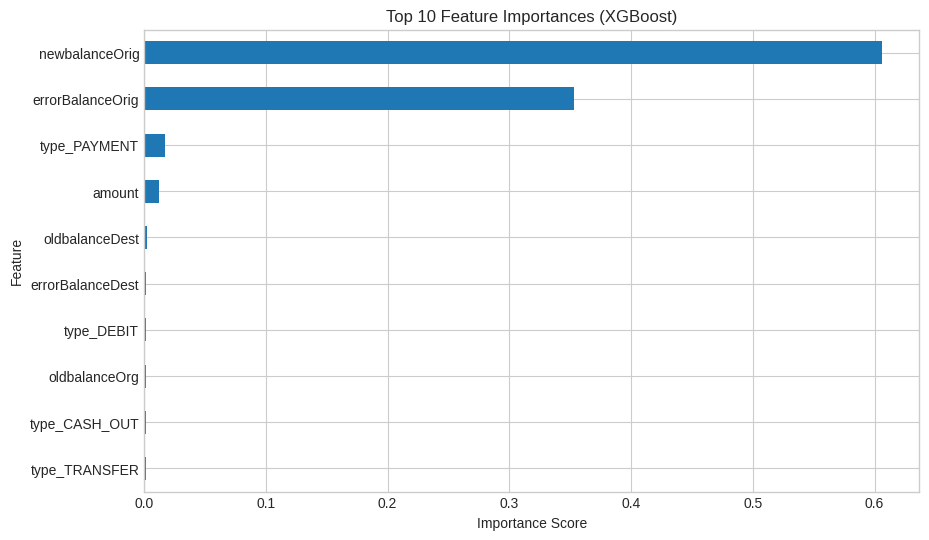

In [38]:
# Feature importance (top 10) from the trained XGBoost classifier
import pandas as pd
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
plt.figure(figsize=(10,6))
feat_importances.sort_values(ascending=True).tail(10).plot(kind='barh')
plt.title('Top 10 Feature Importances (XGBoost)')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.show()

**Key Predictive Factors:**
Some of the most important factors for identfying frauds:
1. errorBalanceOrig: Our engineered feature, capturing discrepancies in the sender's balance, is one of the most important predictor.
2. newbalanceOrig: The sender's balance after the transaction. A value of zero is a huge red flag.
3. amount: The transaction amount.

Other features, but need more in depth analysis to understand their behavior:
1. step: The time unit (hour) in the simulation. This suggests fraud may occur at specific times.
2. type_TRANSFER: Whether the transaction was a transfer.
3. errorBalanceDest: Anomalies in the recipient's balance.


**Do these factors make sense?**

Yes, these factors make perfect sense and align with the description of fraudulent behavior.

Since, there are very common cases where, *agents try to empty the funds by transferring to another account and then cashing out*

The high importance of a **large amount** and **newbalanceOrg directly** reflects this strategy of targeting high-value accounts for large transfers.A resulting newbalanceOrig of zero is the direct outcome of "emptying the funds."

Crucially, the **errorBalanceOrig** feature's top importance suggests that **fraudulent transactions often defy standard accounting logic (e.g., old_balance - amount != new_balance)**, which our engineered feature successfully captured.

**What kind of prevention should be adopted?**

Based on the model's findings, the company should adopt a multi-layered prevention strategy:

1. Real-Time Scoring Engine: Integrate this XGBoost model into the transaction processing system to score every TRANSFER and CASH_OUT in real-time.
2. Risk-Based Authentication: If a transaction receives a high fraud score (e.g., probability > 0.7):
3. Trigger Step-Up Authentication: Require a second factor of authentication (e.g., SMS code, biometric confirmation) before the transaction is processed.
4. For very high scores (> 0.9), especially if it involves emptying an account, place a temporary hold on the transaction and flag it for immediate review by a human analyst.
5. Behavioral Anomaly Detection: monitoring for unusual times of activity or transactions that don't add up financially should be a priority.

**How would you determine if these actions work?**

To measure the effectiveness of the new prevention system, a rigorous A/B testing framework should be implemented.

A. Create Two Groups:
* Control Group (A): A small percentage of users (e.g., 5%) whose transactions are scored by the model but are not subjected to the new interventions. We only observe what the model would have done.
* Test Group (B): The majority of users (95%) who are protected by the new real-time scoring and intervention system.

B. Track Key Performance Indicators (KPIs) for Both Groups:
* Fraud Detection Rate (Recall): What percentage of total fraud volume ($) was caught/prevented in Group B vs. detected in Group A?
* False Positive Rate: How many legitimate transactions in Group B were flagged for intervention? This measures customer friction.
* Customer Impact: Monitor customer support tickets related to blocked transactions.
* Financial Impact: Compare the total financial losses from fraud between the two groups.

By comparing these KPIs over a defined period (e.g., one quarter), the company can precisely quantify the reduction in fraud losses and the impact on customer experience, thereby proving the system's ROI.